In [108]:
import torch
from torch import Tensor
from torch_geometric.data import Data
from typing import TypeAlias

# Cochain is just a tensor over nodes (k=0) or edges (k=1)
Cochain: TypeAlias = Tensor

# PyG's Data class serves as our graph representation
Graph = Data


def coboundary_adjoint(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., M]
    return: [..., N]
    """
    batch_shape = c.shape[:-1]
    num_nodes = g.num_nodes
    senders, receivers = g.edge_index

    res = torch.zeros((*batch_shape, num_nodes))
    res.index_add_(-1, receivers, c, alpha=1)
    res.index_add_(-1, senders, c, alpha=-1)
    return res


def coboundary(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., N]
    return: [..., M]
    """
    senders, receivers = g.edge_index
    return c[..., receivers] - c[..., senders]


def codegree(g: Graph) -> Cochain:
    """
    return: [..., N]
    """
    num_nodes = g.num_nodes
    senders = g.edge_index[0]
    deg = torch.zeros(num_nodes, device=senders.device)
    deg.index_add_(0, senders, torch.ones_like(senders, dtype=deg.dtype))
    return deg


def codegree_at_nonnegative(c: Cochain, g: Graph) -> Cochain:
    """
    c: [..., M]
    return: [..., N]
    """
    num_nodes, batch_shape = g.num_nodes, c.shape[:-1]
    senders = g.edge_index[0]
    senders_exp = senders.expand_as(c)
    m = c >= 0

    deg = torch.zeros((*batch_shape, num_nodes), device=m.device, dtype=m.dtype)
    deg.scatter_add_(-1, senders_exp, c >= 0)
    return deg


def lift(p: Cochain, g: Graph) -> Cochain:
    """
    p: [..., N]
    return: [..., M]
    """
    senders = g.edge_index[0]
    return p[..., senders]


def mass_preserving_lift(p: Cochain, g: Graph) -> Cochain:
    """
    p: [..., N]
    return: [..., M]
    """
    senders = g.edge_index[0]
    cdeg = codegree(g)
    
    return p[..., senders] / cdeg[senders]


def flow_field(p: Cochain, nu: Cochain, g: Graph) -> Cochain:
    """
    p: N | [..., N]
    nu: [..., M]
    return: [..., M]
    """
    return (
        mass_preserving_lift(p, g)  # [..., M]
        * 
        nu # [..., M]
    )


def continuity_equation_euler_step(p: Cochain, nu: Cochain, dt: float, g: Graph) -> Cochain:
    """
    p: N | [..., N]
    nu: [..., M]

    return: [..., N]
    """
    div = coboundary_adjoint(
        flow_field(p, nu, g), # [..., M]
        g,
    ) # [..., N]
    return p + dt * div # [..., N]


In [468]:
from matplotlib.cm import ScalarMappable
import networkx as nx
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np


def plot_edge_flow(g: Data, flow: Tensor, title: str = "Flow Field"):
    """
    Plots edge orientations and flow values on an undirected graph.
    Arrows go from sender to receiver. Color represents the flow value, centered at 0.
    """
    G = nx.Graph()
    edge_index = g.edge_index.cpu().numpy()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in edge_index.T:
        G.add_edge(int(s), int(r))

    if hasattr(g, "pos"):
        pos = g.pos.cpu().numpy()
    else:
        pos = nx.spring_layout(G, seed=42)
    flow_vals = flow.detach().cpu().numpy()

    vmin, vmax = flow_vals.min(), flow_vals.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("viridis")
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    fig, ax = plt.subplots()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=50, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)

    for i, (s, r) in enumerate(edge_index.T):
        if abs(flow_vals[i]) == 0.0:
            continue
        start, end = pos[int(s)], pos[int(r)]
        vec = np.array(end) - np.array(start)
        color = cmap(norm(flow_vals[i]))
        width = 0.5 + 2.5 * abs(flow_vals[i]) / (abs(flow_vals).max() + 1e-8)
        ax.arrow(start[0], start[1], vec[0]*0.85, vec[1]*0.85,
                 head_width=0.1, head_length=0.1, length_includes_head=True,
                 color=color, alpha=0.8, linewidth=width)

    plt.colorbar(sm, ax=ax, label="Flow value (centered at 0)")
    ax.axis("off")
    plt.show()


def plot_0chain(g: Data, cochain: torch.Tensor, title: str = "0-Cochain"):
    """
    Plots a 0-cochain as node colors on the graph.
    """
    values = cochain.detach().cpu().numpy()
    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in g.edge_index.cpu().T:
        G.add_edge(int(s), int(r))

    if hasattr(g, "pos"):
        pos = g.pos.cpu().numpy()
        pos = {int(i): (x.item(), y.item()) for i, (x, y) in enumerate(pos)}
    else:
        pos = nx.spring_layout(G, seed=42)
    vmin, vmax = values.min(), values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("coolwarm")

    fig, ax = plt.subplots()
    ax.set_title(title)
    nodes = nx.draw_networkx_nodes(G, pos, node_color=values, cmap=cmap,
                                   node_size=400, ax=ax, vmin=vmin, vmax=vmax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Value")
    ax.axis("off")
    plt.show()


def plot_1chain(g: Data, cochain: torch.Tensor, title: str = "1-Cochain"):
    """
    Plots a 1-cochain as colored arrows along graph edges (from sender to receiver).
    """
    values = cochain.detach().cpu().numpy()
    edge_index = g.edge_index.cpu().numpy()
    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in edge_index.T:
        G.add_edge(int(s), int(r))

    if hasattr(g, "pos") and g.pos is not None:
        pos = g.pos.cpu().numpy()
        pos = {int(i): (x.item(), y.item()) for i, (x, y) in enumerate(pos)}
    else:
        pos = nx.spring_layout(G, seed=42)
    vmin, vmax = values.min(), values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("coolwarm")

    fig, ax = plt.subplots()
    ax.set_title(title)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=100, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, ax=ax)

    for i, (s, r) in enumerate(edge_index.T):
        if abs(values[i]) == 0.0:
            continue
        start, end = pos[int(s)], pos[int(r)]
        vec = np.array(end) - np.array(start)
        color = cmap(norm(values[i]))
        width = 0.5 + 2.5 * abs(values[i]) / (abs(values).max() + 1e-8)
        ax.arrow(start[0], start[1], vec[0]*0.85, vec[1]*0.85,
                 head_width=0.1, head_length=0.1, length_includes_head=True,
                 color=color, alpha=0.8, linewidth=width)

    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Value")
    ax.axis("off")
    plt.show()


from matplotlib.patches import FancyArrowPatch


def plot_0_and_1chain(g: Data, cochain_0: torch.Tensor, cochain_1: torch.Tensor, title: str = "", ax=None):
    from matplotlib.patches import FancyArrowPatch

    node_values = cochain_0.detach().cpu().numpy()
    edge_values = cochain_1.detach().cpu().numpy()
    edge_index = g.edge_index.cpu().numpy()

    G = nx.DiGraph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in edge_index.T:
        G.add_edge(int(s), int(r))

    if hasattr(g, "pos") and g.pos is not None:
        pos_tensor = g.pos.cpu().numpy()
        pos = {int(i): (x.item(), y.item()) for i, (x, y) in enumerate(pos_tensor)}
    else:
        pos = nx.spring_layout(G, seed=42)

    node_norm = Normalize(vmin=0.0, vmax=0.15)
    # node_norm = Normalize(vmin=node_values.min(), vmax=node_values.max())
    edge_norm = Normalize(vmin=edge_values.min(), vmax=edge_values.max())
    cmap = plt.get_cmap("coolwarm")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    ax.clear()
    ax.set_title(title)

    nx.draw_networkx_nodes(G, pos, node_color=node_values, cmap=cmap,
                           node_size=200, ax=ax, vmin=0.0, vmax=0.15)
    # nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)

    edge_pair_count = {}
    for i, (s, r) in enumerate(edge_index.T):
        if abs(edge_values[i]) == 0.0:
            continue
        start, end = pos[int(s)], pos[int(r)]
        key = (min(int(s), int(r)), max(int(s), int(r)))
        edge_pair_count[key] = edge_pair_count.get(key, 0) + 1
        count = edge_pair_count[key]

        rad = 0.2 * (-1 if s > r else 1) * (count % 2 * 2 - 1)

        color = cmap(edge_norm(edge_values[i]))
        width = 0.5 + 2.5 * abs(edge_values[i]) / (abs(edge_values).max() + 1e-8)

        arrow = FancyArrowPatch(posA=start, posB=end,
                                connectionstyle=f"arc3,rad={rad}",
                                arrowstyle='-|>',
                                color=color, linewidth=width,
                                alpha=0.8, mutation_scale=15)
        ax.add_patch(arrow)

    # Colorbars
    # Left colorbar
    sm_node = ScalarMappable(norm=node_norm, cmap=cmap)
    sm_node.set_array([])
    cax_node = fig.add_axes([0.91, 0.25, 0.02, 0.5])
    # cax_node = fig.add_axes([0.05, 0.25, 0.02, 0.5])
    cbar_node = plt.colorbar(sm_node, cax=cax_node)
    cbar_node.set_label("Probability mass at a node")

    # Right colorbar
    # sm_edge = ScalarMappable(norm=edge_norm, cmap=cmap)
    # sm_edge.set_array([])
    # cbar_edge = plt.colorbar(sm_edge, cax=cax_edge)
    # cbar_edge.set_label("1-Cochain (Edge) Value")

    ax.axis("off")
    return fig  # So we can close it after saving



In [437]:
import torch
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from typing import Callable, Protocol, Tuple
import networkx as nx
from torch_geometric.utils import to_networkx


# --- Continuity Equation Simulation ---


def postprocess(p: Cochain) -> Cochain:
    """
    Due to approximation, sometimes the probability distiribution might be slightly negative or mass may be not equal to 1.
    """
    p = torch.clamp(p, min=0.0)
    p = p / torch.sum(p, dim=-1, keepdim=True) 
    return p



def simulate_continuity_equation(
    p: Cochain, nu_fn: Callable[[float], Cochain], g: Graph, num_steps: int = 1000
) -> Cochain:
    """
    p: [N] | [..., N]
    nu_fn: [T] -> [T, ..., N]
    return: [T, ..., N]
    """
    dt = 1.0 / num_steps
    ts = torch.linspace(0.0, 1.0, steps=num_steps + 1)[:-1] # [T]
    nus = nu_fn(ts) # [T, ..., N]

    p0_batch_shape = torch.broadcast_shapes(nus.shape[1:-1], p.shape[:-1])
    p0 = p.expand(*p0_batch_shape, *p.shape[-1:])
    ps = [p0]
    for nu in nus:
        p = continuity_equation_euler_step(p, nu, dt, g)
        p = postprocess(p)
        ps.append(p)
    ps = torch.stack(ps, dim=0)
    # print(f"{ps.shape=}, {nus.shape=}")
    return ps


# --- Biharmonic Distance ---

def graph_laplacian(g: Graph) -> Tensor:
    """
    Computes symmetric combinatorial Laplacian L = D - A
    """
    edge_index = g.edge_index
    num_nodes = g.num_nodes
    A = to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0)
    D = torch.diag(A.sum(dim=1))
    return D - A


def laplacian_eigenpairs(g: Graph) -> Tuple[Tensor, Tensor]:
    """
    Returns eigenvalues and eigenvectors of the Laplacian.
    """
    L = graph_laplacian(g)
    eigvals, eigvecs = torch.linalg.eigh(L)
    return eigvals, eigvecs


class Premetric(Protocol):
    def distance(self, x: int, y: int) -> float:
        ...

    def __call__(self, x: int, y: int) -> float:
        ...

    def distance_to(self, tau: int) -> Cochain:
        ...


class BiharmonicDistance(Premetric):
    def __init__(self, g: Graph):
        self.graph = g
        eigvals, eigvecs = laplacian_eigenpairs(g)
        self.eigvals = eigvals[1:]  # [K]
        self.eigvecs = eigvecs[:, 1:] # [N, K] <- eigenvectors as columns

    def distance(self, x: Tensor, y: Tensor) -> Tensor:
        phi_x = self.eigvecs[x]
        phi_y = self.eigvecs[y]
        diff_sq = (phi_x - phi_y).pow(2)
        return float((diff_sq / self.eigvals.pow(2)).sum())

    def distance_to(self, tau: Tensor) -> Cochain:
        """
        tau: [...]
        return: [..., N]
        """
        phi_tau = self.eigvecs[tau] # [..., K] # eigenvectors evaluated at tau

        diff_sq = torch.square(self.eigvecs - phi_tau[..., None, :]) # [N, K] - [..., 1, K]
        w = torch.square(self.eigvals) # [K]
        return torch.sum(diff_sq / w, dim=-1)
    

class ShortestPathDistance(Premetric):
    def __init__(self, g: Graph):
        self.graph = g

        g_nx = to_networkx(g, to_undirected=False)

        # Use NetworkX shortest path computation
        num_nodes = g.num_nodes
        nx_distances = dict(nx.all_pairs_shortest_path_length(g_nx))

        self.distances = torch.full((num_nodes, num_nodes), float('inf'))

        # Fill distances
        for src, targets in nx_distances.items():
            for dst, d in targets.items():
                self.distances[src, dst] = d

    def distance(self, x: int, y: int) -> float:
        return float(self.distances[x][y])

    def distance_to(self, tau: int) -> Cochain:
        return self.distances[tau]

In [438]:
import torch
from torch import Tensor
from typing import Callable
import math
from functorch import jacfwd


def linear_schedule(t: Tensor) -> Tensor:
    """
    t: [...]
    return: [...]
    """
    return 1.0 - t


def scale_flow_by_schedule(flow: Cochain, t: float | Tensor):
    """
    flow: [..., M]
    t: [T]
    return: [T, ..., M]
    """
    t = torch.as_tensor(t)

    dlogkappat = -1.0 / (1.0 - t)
    if t.ndim == 0:
        return flow * dlogkappat
    else:
        return torch.einsum('t, t...m -> t...m', dlogkappat, flow)


def conditional_flow_field(tau: int, rho: Premetric, t: float | Tensor, g: Graph, *, scale_by_schedule: bool = False) -> Cochain:
    """
    tau: [...], 
    t: [T],
    return: [T, ..., N]
    """
    t = torch.as_tensor(t)

    rho_tau = rho.distance_to(tau) # [..., N]
    
    # dlogkappa = jacfwd(lambda x: torch.log(linear_schedule(x)), t)
    delta_rho_tau = coboundary(rho_tau, g) # [..., M]

    # Take only positive components so that the non-negativity of mass is preserved
    codeg = codegree(g) # [N]
    codeg_at_nonnegative = codegree_at_nonnegative(-delta_rho_tau, g) # [..., N]
    Lrho_tau_scaled = lift(codeg / codeg_at_nonnegative * rho_tau, g) # [..., M]

    res = torch.where(
        (delta_rho_tau <= 0) & (lift(rho_tau, g) > 0), # [..., M] & [..., M]
        Lrho_tau_scaled / delta_rho_tau, # [..., M]
        torch.zeros_like(delta_rho_tau)
    ) # [..., M]

    res = res[None].expand(*t.shape, *res.shape) # [T, ..., M]
    if scale_by_schedule:
        res = scale_flow_by_schedule(res, t)
            
    return res 


def uniform_distribution(g: Graph) -> Cochain:
    """
    return: [N]
    """
    num_nodes = g.num_nodes
    return torch.ones(num_nodes) / num_nodes

In [439]:
def interpolate(xp: Tensor, yp: Tensor, x: Tensor) -> Tensor:
    """
    xp: [N]
    yp: [N, ...]
    x: [M] 
    return: [M, ...]
    """
    idx = torch.searchsorted(xp, x, right=True)
    idx0 = idx - 1
    idx1 = idx

    x0 = xp[idx0]
    x1 = xp[idx1]
    y0 = yp[idx0]
    y1 = yp[idx1]

    w = (x - x0) / (x1 - x0)
    return (
        torch.einsum('w, w... -> w...', 1 - w, y0)
        + 
        torch.einsum('w, w... -> w...', w, y1)
    )

    return (1 - w[:, None]) * y0 + w[:, None] * y1


def conditional_flow_matching_loss(
    tau: int | Tensor,
    rho: Premetric,
    p0: Cochain,
    model: Callable[[float], Cochain],
    g: Graph,
    *,
    num_t_samples: int,
    num_steps: int,
    cache: dict[int, Tensor] | None = None,
) -> Tensor:
    tau = torch.as_tensor(tau)


    # 1. Simulate p_t over [0, 1]
    ts = torch.linspace(0, 1, num_steps + 1) # [T']
    if cache is not None:
        pts = torch.stack([cache[tau_] for tau_ in tau.flatten().tolist()], dim=-1)
        pts = pts.reshape((pts.shape[0], *tau.shape, pts.shape[1]))
    else:
        pts = simulate_continuity_equation(
            p0, 
            lambda t: conditional_flow_field(tau, rho, t, g, scale_by_schedule=True),
            g, 
            num_steps,
        ) # [T, ..., N]

    # 2. Sample t values
    t_samples = torch.rand(num_t_samples) # [T]

    # 3. Interpolate p_t at t samples
    pts_samples = interpolate(ts, pts, t_samples)  # [T, ..., N]
    # print(f"{pts.shape=}, {pts_samples.shape=}")
    Lpts_samples = mass_preserving_lift(pts_samples, g)  # [T, ..., M]

    # 4. Compute target flow field and model predictions
    targets = conditional_flow_field(tau, rho, t_samples, g, scale_by_schedule=False) # [T, ..., M]
    preds = -model(t_samples) # [T, M] NOTE negative on purpose because we later scale by -1.0 / (1.0 - t_samples)

    # 5. Weighted L2 loss
    broadcasted_shape = (targets.shape[0], *(1,) * (targets.ndim - 2), targets.shape[-1])

    # print(f"{targets.shape=}, {preds.shape=}, {broadcasted_shape=}, {t_samples.shape=}")

    diff = preds.reshape(broadcasted_shape) - targets

    # scale by schedule
    dlogkappat = -1.0 / (1.0 - t_samples)
    diff = torch.einsum('t, t...m -> t...m', dlogkappat, diff)

    sq_diff = torch.square(diff) * Lpts_samples


    loss = torch.mean(sq_diff)
    # loss = torch.mean(torch.sum(sq_diff, dim=-1))
    return loss


def conditional_flow_matching_loss_deterministic(
    tau: int | Tensor,
    rho: Premetric,
    p0: Cochain,
    model: Callable[[float], Cochain],
    g: Graph,
    *,
    num_t_samples: int,
    num_steps: int,
    cache: dict[int, Tensor] | None = None,
) -> Tensor:
    tau = torch.as_tensor(tau)


    # 1. Simulate p_t over [0, 1]
    ts = torch.linspace(0, 1, num_steps + 1) # [T']
    if cache is not None:
        pts = torch.stack([cache[tau_] for tau_ in tau.flatten().tolist()], dim=0) # [..., T, N]
        pts = pts.reshape((*tau.shape, *pts.shape[1:]))
        pts = pts.permute((-2, *range(pts.ndim - 2), -1))
        # pts = pts.reshape((pts.shape[0], *tau.shape, pts.shape[1]))
    else:
        pts = simulate_continuity_equation(
            p0, 
            lambda t: conditional_flow_field(tau, rho, t, g, scale_by_schedule=True),
            g, 
            num_steps,
        ) # [T, ..., N]

    # 2. Sample t values
    t_samples = ts[:-1]
    pts_samples = pts[:-1]
    Lpts_samples = mass_preserving_lift(pts_samples, g)  # [T, ..., M]

    # 4. Compute target flow field and model predictions
    targets = conditional_flow_field(tau, rho, t_samples, g, scale_by_schedule=False) # [T, ..., M]
    preds = -model(t_samples) # [T, M] NOTE negative on purpose because we later scale by -1.0 / (1.0 - t_samples)

    # 5. Weighted L2 loss
    broadcasted_shape = (targets.shape[0], *(1,) * (targets.ndim - 2), targets.shape[-1])
    diff = preds.reshape(broadcasted_shape) - targets

    # scale by schedule
    dlogkappat = -1.0 / (1.0 - t_samples)
    diff = torch.einsum('t, t...m -> t...m', dlogkappat, diff)
    sq_diff = torch.square(diff) * Lpts_samples


    loss = torch.mean(sq_diff)
    # loss = torch.mean(torch.sum(sq_diff, dim=-1))
    return loss


In [318]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class TimeEncoder(nn.Module):
    def __init__(self, time_dim: int):
        super().__init__()
        self.freqs = nn.Parameter(torch.randn(time_dim), requires_grad=True)
        self.proj = nn.Linear(time_dim * 2, time_dim)  # Fix: match input shape

    def forward(self, t: float, num_nodes: int) -> torch.Tensor:
        t_tensor = torch.full((num_nodes, 1), t, dtype=torch.float32, device=self.freqs.device)
        sin = torch.sin(self.freqs * t_tensor)
        cos = torch.cos(self.freqs * t_tensor)
        sin_cos = torch.cat([sin, cos], dim=-1)  # [num_nodes, 2 * time_dim]
        return self.proj(sin_cos)  # [num_nodes, time_dim]
    

class TimeConditionedFlowGNN(nn.Module):
    def __init__(self, node_input_dim: int, time_dim: int, hidden_dim: int, heads: int = 4):
        super().__init__()
        self.time_encoder = TimeEncoder(time_dim)
        self.gat = GATConv(node_input_dim + time_dim, hidden_dim, heads=heads, concat=True)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * heads * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # non-negative output
        )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, t: float) -> torch.Tensor:
        t_emb = self.time_encoder(t, x.size(0))  # [num_nodes, time_dim]
        x_t = torch.cat([x, t_emb], dim=-1)
        h = self.gat(x_t, edge_index)  # [num_nodes, hidden_dim * heads]

        i, j = edge_index  # edge_index: [2, num_edges]
        edge_inputs = torch.cat([h[i], h[j]], dim=-1)
        return self.edge_mlp(edge_inputs).squeeze(-1)  # [num_edges]


In [319]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class FlowGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.gnn = GCNConv(in_dim, hidden_dim)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # ensure non-negative output
        )

    def forward(self, x, edge_index):
        h = self.gnn(x, edge_index)
        # Create edge features by concatenating h_i and h_j
        i, j = edge_index
        edge_feat = torch.cat([h[i], h[j]], dim=-1)
        return self.edge_mlp(edge_feat).squeeze(-1)


def add_onehot_encoding(data: Data) -> Data:
    data.x = torch.eye(data.num_nodes)
    return data

In [348]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def fourier_encode(t, num_freqs=8):
    freqs = 2 ** torch.arange(0, num_freqs).float() * torch.pi
    freqs = freqs.to(t.device)
    ts = t.unsqueeze(-1)  # shape: [B, 1]
    return torch.cat([ts, torch.sin(freqs * ts), torch.cos(freqs * ts)], dim=-1)  # [B, 1 + 2 * num_freqs]

class TimeToEdgeFlowMLP(nn.Module):
    def __init__(self, hidden_dim: int, num_edges: int, num_freqs: int = 16):
        super().__init__()
        self.num_freqs = num_freqs
        input_dim = 1 + 2 * num_freqs  # raw t + sin/cos Fourier features

        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden1 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim + input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim + input_dim, num_edges)

    def forward(self, t: float | torch.Tensor) -> torch.Tensor:
        t = torch.as_tensor(t)

        # Fourier encode time + keep raw t
        # t_feat = fourier_encode(t.squeeze(-1), num_freqs=self.num_freqs)  # shape: [B, 1 + 2 * num_freqs]
        t_feat = fourier_encode(t, num_freqs=self.num_freqs)  # shape: [B, 1 + 2 * num_freqs]

        h0 = F.relu(self.input(t_feat))
        h0t = torch.cat([h0, t_feat], dim=-1)
        h1 = F.relu(self.hidden1(h0t) + h0)
        h1t = torch.cat([h1, t_feat], dim=-1)
        h2 = F.relu(self.hidden2(h1t) + h1)
        h2t = torch.cat([h2, t_feat], dim=-1)

        h3 = self.output(h2t)
        # out = F.relu(h3)
        out = F.softplus(h3)

        # out = F.softplus(self.output(h2t))  # non-negative output
        return out


In [349]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize


def build_circle_graph(n: int) -> Data:
    edge_index = torch.tensor(
        [[i for i in range(n)] + [(i + 1) % n for i in range(n)],
         [(i + 1) % n for i in range(n)] + [i for i in range(n)]],
        dtype=torch.long
    )
    x = torch.ones((n, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def build_karate_graph() -> Data:
    G = nx.karate_club_graph()
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)  # Make undirected

    num_nodes = G.number_of_nodes()
    x = torch.ones((num_nodes, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def build_example_graph() -> Data:
    edges = torch.tensor([
        [0, 1],
        [1, 2],
        [2, 0],
        [2, 3],
        [3, 4]
    ], dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edges, edges[[1, 0]]], dim=1)  # Make undirected

    num_nodes = 5
    x = torch.ones((num_nodes, 1), dtype=torch.float32)
    edge_attr = torch.ones((edge_index.shape[1], 1), dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def plot_graph(g: Data):
    G = nx.Graph()
    G.add_nodes_from(range(g.num_nodes))
    edges = g.edge_index.cpu().numpy().T
    G.add_edges_from([tuple(edge) for edge in edges])
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=600)
    plt.title("Example Graph")
    plt.show()


def plot_laplacian_eigenvectors(g: Graph, num_vecs: int = 4):
    """
    Plot the first few Laplacian eigenvectors (excluding the trivial one).
    Each eigenvector is shown as node colors.
    """
    eigvals, eigvecs = laplacian_eigenpairs(g)

    G = nx.Graph()
    for i in range(g.num_nodes):
        G.add_node(i)
    for s, r in zip(g.edge_index[0], g.edge_index[1]):
        G.add_edge(int(s), int(r))

    pos = nx.spring_layout(G, seed=42)

    fig, axs = plt.subplots(1, num_vecs, figsize=(4 * num_vecs, 4))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    for i in range(num_vecs):
        eigvec = eigvecs[:, i]
        ax = axs[i]
        nodes = nx.draw_networkx_nodes(
            G, pos, node_color=eigvec, cmap="coolwarm", ax=ax, vmin=-1, vmax=1
        )
        nx.draw_networkx_edges(G, pos, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        ax.set_title(f"Eigenvector {i}\nλ = {eigvals[i]:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_biharmonic_distance(g: Data, source_node: int):
    from scipy.sparse import coo_matrix
    from scipy.sparse.linalg import eigsh

    num_nodes = g.num_nodes
    edges = g.edge_index.cpu().numpy()
    row, col = edges
    data = np.ones(row.shape)
    A = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
    D = np.diag(A.sum(axis=1).A1)
    L = D - A.toarray()

    eigvals, eigvecs = eigsh(L, k=num_nodes, which='SM')
    eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]

    phi_x = eigvecs[source_node]
    diff = eigvecs - phi_x
    distances = (diff**2 / eigvals**2).sum(axis=1)

    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(zip(row, col))
    if hasattr(g, "pos"):
        pos = g.pos
        pos = {i: (x.item(), y.item()) for i, (x, y) in enumerate(pos)}
    else:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(6, 5))
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=distances,
        cmap="viridis",
        node_size=500
    )
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.colorbar(nodes, label=f"Biharmonic distance from node {source_node}")
    plt.title(f"Biharmonic Distance from Node {source_node}")
    plt.axis("off")
    plt.show()


In [350]:
g = build_circle_graph(20)

probs = torch.zeros(20)
# probs[[0, 5, 10, 15]] = 0.25
# dist = torch.distributions.Categorical(probs=probs)
# taus = dist.sample((1024,))
taus = torch.ones(1024, dtype=int)
taus[:256] *= 0
taus[256:512] *= 5
taus[512:768] *= 10
taus[768:1024] *= 15


all_taus = [0, 5, 10, 15]

In [351]:
from torch.utils.data import DataLoader, Dataset


class FlowMatchingDataset(Dataset):

    def __init__(self, x):
        super().__init__()
        self.x=x

    def __getitem__(self, index) -> Tensor:
        return self.x[index]
    
    def __len__(self) -> int:
        return len(self.x)


In [352]:
num_edges = g.edge_index.shape[1]
model = TimeToEdgeFlowMLP(hidden_dim=32, num_edges=num_edges)


dataset = FlowMatchingDataset(taus)
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
num_t_samples = 1000
num_steps = 1000



num_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
rho = ShortestPathDistance(g)
p0 = uniform_distribution(g)


cache = {
    tau: simulate_continuity_equation(
        p=p0, 
        nu_fn=lambda t: conditional_flow_field(tau=tau, rho=rho, t=t, g=g, scale_by_schedule=True),
        g=g, 
        num_steps=num_steps
    )
    for tau in all_taus
}


losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for tau in dataloader:
        optimizer.zero_grad()
        loss = conditional_flow_matching_loss(
            tau=tau,
            rho=rho,
            p0=p0,
            model=model,
            g=g,
            num_t_samples=num_t_samples,
            num_steps=num_steps,
            cache=cache
        )
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")


plt.plot(losses)


pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.shape=torch.Size([1001, 64, 20]), pts_samples.shape=torch.Size([1000, 64, 20])
pts.

KeyboardInterrupt: 

In [336]:
simulate_continuity_equation(
    p=p0, 
    nu_fn=lambda t: conditional_flow_field(tau=0, rho=rho, t=t, g=g, scale_by_schedule=True),
    g=g,
    num_steps=num_steps
)[-1]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [340]:
flows = conditional_flow_field(
    tau=taus,
    rho=rho,
    t=torch.linspace(0.0, 1.0, num_steps + 1)[:-1],
    g=g,
    scale_by_schedule=False,
)

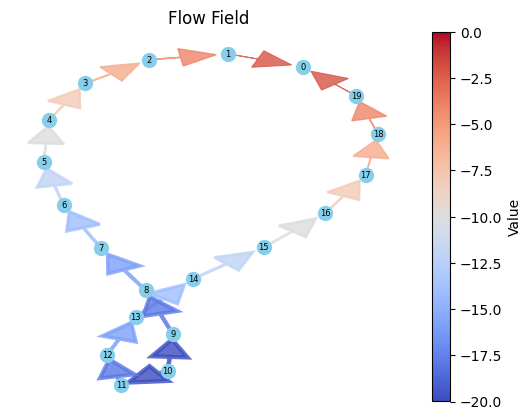

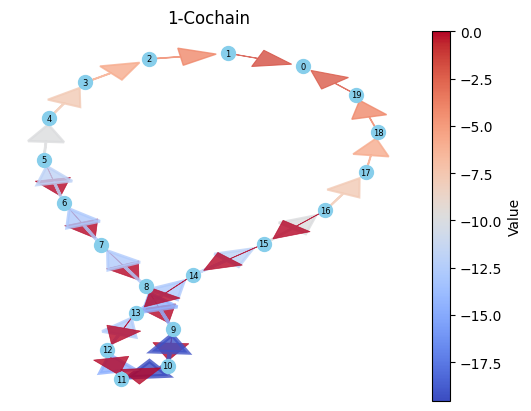

In [247]:
i = 50
j = 0

plot_1chain(g, flows[i, j], title="Flow Field")
preds = -model(0.99)
preds[preds > -1e-4] = 0
plot_1chain(g, preds)

In [346]:
simulate_continuity_equation(
    p=p0,
    nu_fn=lambda t: scale_flow_by_schedule(-model(t), t),
    g=g,
    num_steps=1000
)[-1]

tensor([0.0068, 0.0615, 0.0281, 0.1042, 0.0000, 0.0034, 0.0624, 0.0000, 0.1835,
        0.0032, 0.0302, 0.0000, 0.3509, 0.0000, 0.0545, 0.0000, 0.0039, 0.0000,
        0.1041, 0.0034], grad_fn=<SelectBackward0>)

/tmp/ipykernel_2638656/4040371490.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  pos_tensor = torch.tensor(pos, dtype=torch.float32)


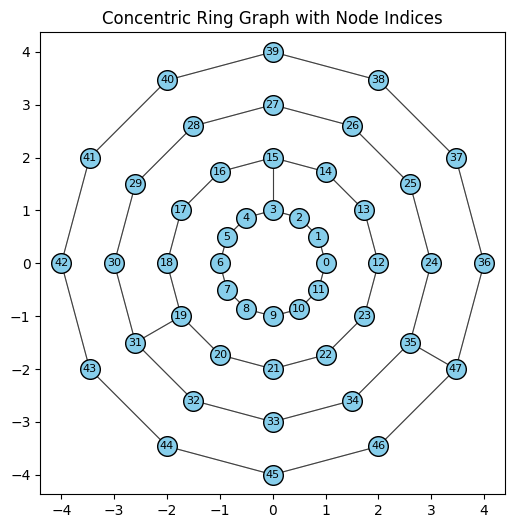

In [353]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

def build_centered_bridge_concentric_ring_graph(num_rings=4, nodes_per_ring=12, radius_step=1.0, num_bridges=3) -> Data:
    pos = []
    edge_index = []
    ring_node_indices = []
    node_offset = 0

    for r in range(num_rings):
        radius = (r + 1) * radius_step
        theta = np.linspace(0, 2 * np.pi, nodes_per_ring, endpoint=False)
        xs = radius * np.cos(theta)
        ys = radius * np.sin(theta)
        ring_pos = np.stack([xs, ys], axis=1)

        pos.extend(ring_pos)
        ring_node_indices.append(np.arange(node_offset, node_offset + nodes_per_ring))

        # Intra-ring cycle connections
        for i in range(nodes_per_ring):
            a = node_offset + i
            b = node_offset + (i + 1) % nodes_per_ring
            edge_index.extend([[a, b], [b, a]])

        node_offset += nodes_per_ring

    # Inter-ring bridges: spaced evenly around center
    d = np.pi / 2
    bridge_angles = np.linspace(0 + d, 2 * np.pi + d, num_bridges, endpoint=False)
    for r in range(num_bridges):  # r = ring index for lower ring
        lower_ring = ring_node_indices[r]
        upper_ring = ring_node_indices[r + 1]

        theta = np.linspace(0, 2 * np.pi, nodes_per_ring, endpoint=False)

        # Find closest nodes in both rings to the bridge angle
        angle = bridge_angles[r]
        lower_idx = np.argmin(np.abs(((theta - angle + np.pi) % (2 * np.pi)) - np.pi))
        upper_idx = np.argmin(np.abs(((theta - angle + np.pi) % (2 * np.pi)) - np.pi))

        a = lower_ring[lower_idx]
        b = upper_ring[upper_idx]
        edge_index.extend([[a, b], [b, a]])

    pos_tensor = torch.tensor(pos, dtype=torch.float32)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.eye(len(pos))  # one-hot node features

    return Data(x=x, pos=pos_tensor, edge_index=edge_index_tensor)


# === Visualize with node labels
g = build_centered_bridge_concentric_ring_graph(num_rings=4, nodes_per_ring=12, num_bridges=3)
pos = g.pos.numpy()
plt.figure(figsize=(6, 6))
for i, j in g.edge_index.t():
    plt.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]], 'k-', linewidth=0.8, alpha=0.5, zorder=1)
plt.scatter(pos[:, 0], pos[:, 1], c='skyblue', s=200, edgecolors='black')

# Add node labels
for idx, (x, y) in enumerate(pos):
    plt.text(x, y, str(idx), fontsize=8, ha='center', va='center', color='black')

plt.axis('equal')
plt.title("Concentric Ring Graph with Node Indices")
plt.show()


In [383]:
import torch
from torch.distributions import Categorical

# Unnormalized logits or probabilities for 5 categories
probs = torch.zeros(g.num_nodes)
probs[7] = 0.25
probs[11] = 0.25
probs[19:24] = 0.1
probs = probs / probs.sum()

# all_taus = [7, 11, 19, 20, 21, 22, 23]

probs = torch.zeros(g.num_nodes)
probs[[7, 11, 19, 20, 21, 22, 23]] = 1.0
probs = probs / probs.sum()
all_taus = [7, 11, 19, 20, 21, 22, 23]

# probs = torch.zeros(g.num_nodes)
# probs[[7, 11]] = 0.5
# all_taus = [7, 11]


# Create categorical distribution
dist = Categorical(probs=probs)

taus = dist.sample((2048,))


p0 = torch.zeros(g.num_nodes)
p0[36:48] = 1/12
p0 = p0 / p0.sum()

# p0 = uniform_distribution(graph)

In [472]:
num_edges = g.edge_index.shape[1]
model = TimeToEdgeFlowMLP(hidden_dim=64, num_edges=num_edges)


dataset = FlowMatchingDataset(taus)
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
num_t_samples = 1000
num_steps = 1000



num_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
rho = ShortestPathDistance(g)
# rho = BiharmonicDistance(g)
# p0 = uniform_distribution(g)


cache = {
    tau: simulate_continuity_equation(
        p=p0, 
        nu_fn=lambda t: conditional_flow_field(tau=tau, rho=rho, t=t, g=g, scale_by_schedule=True),
        g=g, 
        num_steps=num_steps
    )
    for tau in all_taus
}


losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for tau in dataloader:
        optimizer.zero_grad()
        loss = conditional_flow_matching_loss_deterministic(
            tau=tau,
            rho=rho,
            p0=p0,
            model=model,
            g=g,
            num_t_samples=num_t_samples,
            num_steps=num_steps,
            cache=cache
        )
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")


plt.plot(losses)

Epoch 0: Loss = 195.9822
Epoch 1: Loss = 93.1416
Epoch 2: Loss = 53.5796
Epoch 3: Loss = 48.8159
Epoch 4: Loss = 47.4737
Epoch 5: Loss = 46.7307
Epoch 6: Loss = 45.8995
Epoch 7: Loss = 45.1225
Epoch 8: Loss = 44.1825
Epoch 9: Loss = 43.6030
Epoch 10: Loss = 43.1768
Epoch 11: Loss = 43.0122
Epoch 12: Loss = 42.8330
Epoch 13: Loss = 42.7954
Epoch 14: Loss = 42.6622
Epoch 15: Loss = 42.6538
Epoch 16: Loss = 42.4768
Epoch 17: Loss = 42.4683
Epoch 18: Loss = 42.5502
Epoch 19: Loss = 42.6325
Epoch 20: Loss = 42.6430
Epoch 21: Loss = 42.6924
Epoch 22: Loss = 42.4965
Epoch 23: Loss = 42.4597
Epoch 24: Loss = 42.4439
Epoch 25: Loss = 42.3583
Epoch 26: Loss = 42.5244
Epoch 27: Loss = 42.4612
Epoch 28: Loss = 42.3794
Epoch 29: Loss = 42.4061
Epoch 30: Loss = 42.3992
Epoch 31: Loss = 42.4042
Epoch 32: Loss = 42.4689
Epoch 33: Loss = 42.4177
Epoch 34: Loss = 42.4110
Epoch 35: Loss = 42.3828
Epoch 36: Loss = 42.3775
Epoch 37: Loss = 42.3900
Epoch 38: Loss = 42.3705
Epoch 39: Loss = 42.3533
Epoch 40:

KeyboardInterrupt: 

# Looks like there is a mistake related to conditional vector fields. Specifically, for some taus, the conditional field does not produce a delta distribution at the conditioning point

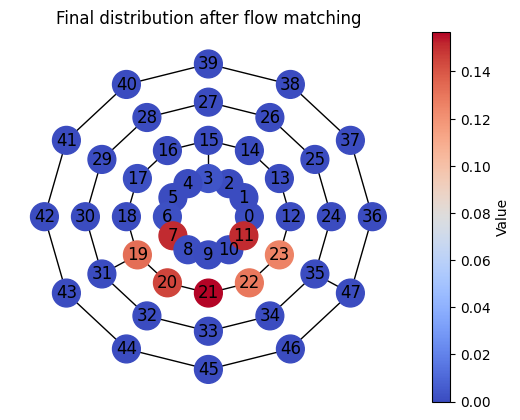

In [475]:
num_steps = 100

nu_fn = lambda t: scale_flow_by_schedule(-model(t), t)
ts = torch.linspace(0.0, 1.0, num_steps + 1)

nus = nu_fn(ts[:-1]) # [T, ..., N]
pts = simulate_continuity_equation(
    p=p0,
    nu_fn=nu_fn,
    g=g,
    num_steps=num_steps
)
p1 = pts[-1]


plot_0chain(
    g, 
    p1, 
    title="Final distribution after flow matching",
)

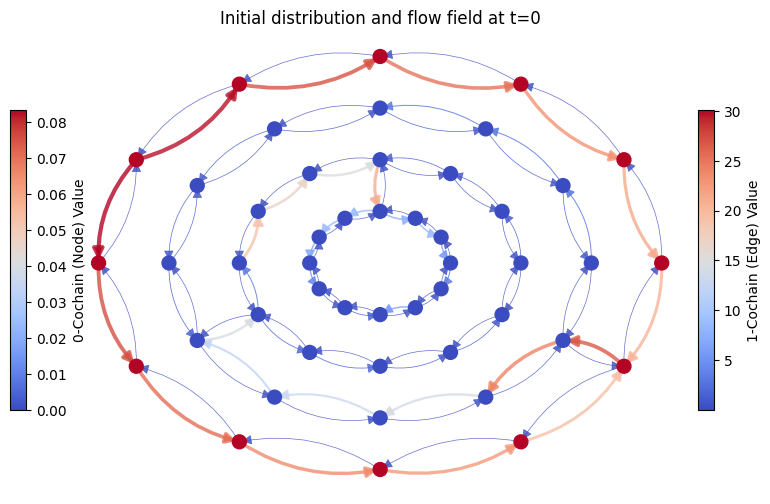

In [408]:
plot_0_and_1chain(
    g, 
    p0,
    nus[0],
    title="Initial distribution and flow field at t=0",
)

In [460]:
import os
import imageio
import torch
import matplotlib.pyplot as plt

def create_gif_from_cochains(g, cochain_0_list, cochain_1_list, ts, gif_path="cochains.gif", frame_duration=0.1):
    """
    Create a GIF from lists of 0- and 1-cochains plotted in sequence.

    Args:
        g: PyG Data object with graph structure and optional positions.
        cochain_0_list: list of 0-cochain tensors (nodes).
        cochain_1_list: list of 1-cochain tensors (edges).
        gif_path: output file path for GIF.
        frame_duration: duration of each frame in seconds.
    """
    assert len(cochain_0_list) == len(cochain_1_list), "Cochain lists must be of the same length."

    filenames = []
    for i, (c0, c1, t) in enumerate(zip(cochain_0_list, cochain_1_list, ts)):
        t = t.item()
        fig, ax = plt.subplots(figsize=(10, 6))  # Fixed size
        plot_0_and_1chain(g, c0, c1, title=f"{t=:.3f}", ax=ax)

        frame_path = f"frame_{i:03d}.png"
        fig.savefig(frame_path, dpi=100)  # <- no bbox_inches to ensure consistent canvas
        plt.close(fig)
        filenames.append(frame_path)
        print(f"{i / len(ts):.2f}", end="\r")

    # Create GIF
    images = [imageio.imread(fname) for fname in filenames]
    imageio.mimsave(gif_path, images, duration=frame_duration)

    # Clean up temporary frame images
    # for fname in filenames:
    #     os.remove(fname)

    print(f"GIF saved to {gif_path}")

In [476]:
nus_ext = torch.concat([nus, nus[-1:]], dim=0)
create_gif_from_cochains(
    g, pts, nus_ext, ts
)

/tmp/ipykernel_2638656/1286702023.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fname) for fname in filenames]


GIF saved to cochains.gif


In [477]:
# Create GIF
filenames = [
    f"frame_{i:03d}.png" for i in range(len(pts))
]
gif_path='./cochains_slower.gif'

images = [imageio.imread(fname) for fname in filenames]
imageio.mimsave(gif_path, images, duration=0.3)

# # Clean up temporary frame images
# for fname in filenames:
#     os.remove(fname)

print(f"GIF saved to {gif_path}")

/tmp/ipykernel_2638656/2341044067.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fname) for fname in filenames]


GIF saved to ./cochains_slower.gif


In [429]:
shapes = [img.shape for img in images]

In [431]:
len(shapes)

101

In [433]:
shapes[90]

(504, 779, 4)

In [166]:
tau = 23


torch.set_default_dtype(torch.float64)

simulate_continuity_equation(
    p=p0, 
    nu_fn=lambda t: conditional_flow_field(tau=tau, rho=rho, t=t, g=g),
    g=g, 
    num_steps=100
)[-1][tau]

tensor(1.0000)

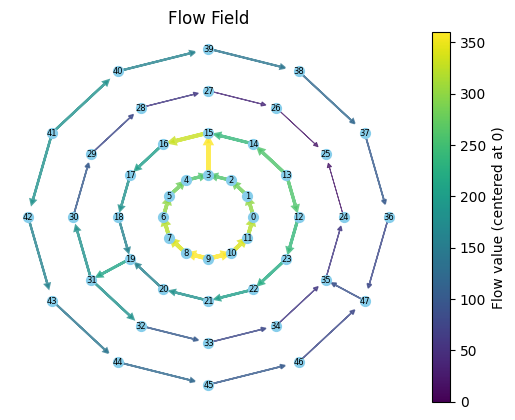

In [138]:
tau = 25
t = 0.9
plot_edge_flow(
    g,
    conditional_flow_field(tau=tau, rho=rho, t=t, g=g),
)

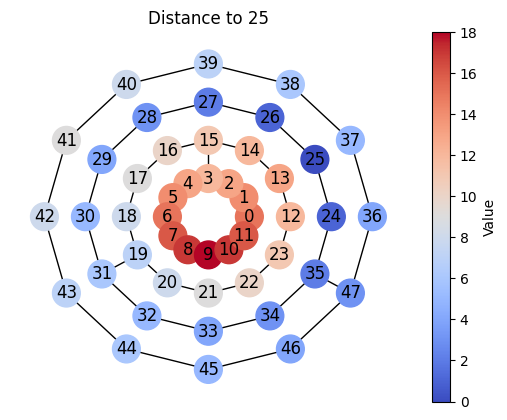

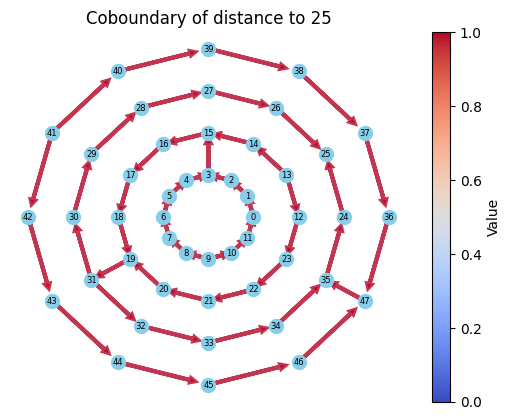

In [140]:
tau = 25
f = rho.distance_to(tau)
plot_0chain(
    g,
    f,
    title=f"Distance to {tau}",
)
df = coboundary(f, g)
df = -torch.clip(df, max=0)
plot_1chain(
    g,
    df,
    title=f"Coboundary of distance to {tau}",
)

In [108]:
f[33], f[34], f[35]

(tensor(12.8889), tensor(6.7031), tensor(7.9722))

In [ ]:
g = build_circle_graph(10)
tau = 5  # Target node

# Initial uniform distribution over nodes
p0 = uniform_distribution(g)

# Biharmonic metric and conditional vector field
rho = ShortestPathDistance(g)
nu_fn = lambda t: conditional_flow_field(tau, rho, t, g=g, scale_by_schedule=True)
# nu_fn = lambda t: scale_flow_by_schedule(conditional_flow_field(tau, rho, t, g=g), t)

# Simulate and collect all intermediate states
trajectory = simulate_continuity_equation(p0, nu_fn, num_steps=100, g=g)

# Extract final state
p_final = trajectory[-1]

# Print or plot result
print("Final distribution coefficients:", p_final)


rho_tau = rho.distance_to(tau)
distances = torch.vstack([torch.inner(rho_tau, c) for c in trajectory])

Final distribution coefficients: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


(0.0, 2.0)

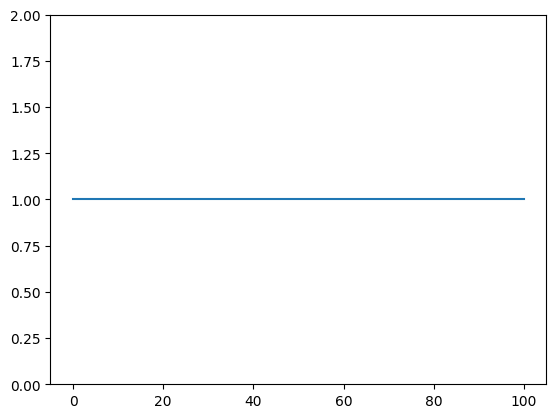

In [200]:
plt.plot(torch.sum(trajectory, dim=1))
plt.ylim(0, 2)

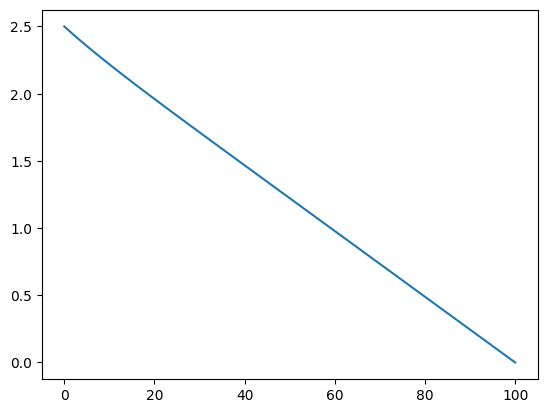

In [201]:
plt.plot(distances)

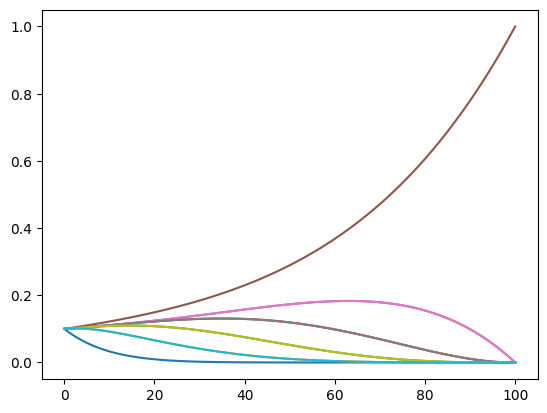

In [202]:
plt.plot(trajectory);

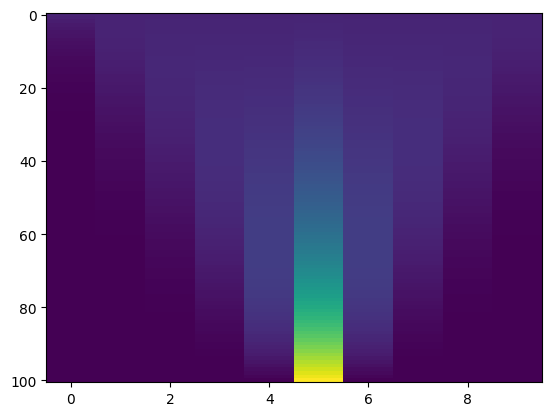

In [203]:
plt.imshow(trajectory, aspect='auto', cmap='viridis')